## Load libraries

In [1]:
library(RColorBrewer)
library(plyr)
library(dplyr)
library(ggplot2)
library(reshape)
library(reshape2)
library(tidyverse)
library(data.table)
library(Rtsne)
library(ggrepel)
library(repr)

theme_nogrid = function(...) theme_bw() + theme(axis.line = element_line(colour = "black"),
                            panel.grid.major = element_blank(),
                             panel.grid.minor = element_blank(),
                             panel.background = element_blank())



Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


── Attaching packages ────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ───────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()  

## Set paths to reference files

In [2]:
cancers=c('ccRCC','CRC','CESC','HNSCC','UCEC','GBM','BRCA','OV','MM','PDAC','BRCA_Basal','MM','OV')

#ATAC project color scales
path_to_ATAC_colors='../data/Colors_panatac_v2.0.rds'

#Matrix with accessibility averaged per tumor cells from each sample, and per normal cells from tissue
path_to_ATAC_average_matrix='../data/snATAC/Average_accessibility_matrix.DataSlot.20230212.tsv'

#Cell counts per each cell group in matrix with average ATAC accessibility
path_to_ATAC_average_matrix_meta='../data/snATAC/Cell_count_perGroup.forAverageAccessibilityMatrix.20230212.tsv'

#ATAC catalog
path_to_ATAC_catalog='../data/ATAC_catalog.20220114.v2.txt'

#Tissue- and cancer-specific DACRs plotted in 1d, Supplementary Table S2c
path_to_ATAC_DACRs_1d='../data/snATAC/Table_S2c_selected_tiss_cancer_DACRs.txt' 

## Set color scales

In [3]:
cols=readRDS(path_to_ATAC_colors)
dis_cols_ed <- cols$Cancer
dis_cols_ed=c('#C69158',dis_cols_ed)
names(dis_cols_ed)[1]='CEAD'

In [4]:
#Read catalog
cat=read_delim(path_to_ATAC_catalog,delim='\t')
cat=as.data.frame(cat)
colnames(cat)=gsub(' ','_',colnames(cat))
cat$Disease_Type=ifelse(cat$Disease_Type=='PKD','ccRCC',cat$Disease_Type)

cat$Piece_ID=paste(cat$Disease_Type,cat$Piece_ID,sep='_')
cat=cat %>% dplyr::select ('Piece_ID','Sample_Type')
colnames(cat)[2]=c('Sample_type')

Rows: 225 Columns: 12
── Column specification ───────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): Disease Type, Sample ID, Case ID, Piece_ID, Sample Type, Data Type...
lgl  (2): Include in the downstream analysis, Include in immune

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
#Read average accessibility matrix
tab_1=fread(path_to_ATAC_average_matrix)
tab_1=as.data.frame(tab_1)
rownames(tab_1)=tab_1[,1]
tab_1=tab_1[,-1]
tab=tab_1

Warning message in fread(path_to_ATAC_average_matrix):
“Detected 245 column names but the data has 246 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [6]:
#Remove cell groups with too few number of cells
meta=read.table(path_to_ATAC_average_matrix_meta,sep='\t',header=T)
meta$Cell_type=gsub(' ','-',meta$Cell_type)
meta_s=meta[meta$Cell_count>=20 ,]
colnames(tab)=gsub('\\.','-',colnames(tab))


In [7]:
#Add row annotation
tab=t(tab)
rownames(tab)=gsub(' ','-',rownames(tab))
tab=tab[rownames(tab) %in% meta_s$Cell_type,]

row_annot=as.data.frame(rownames(tab))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)_(.*)','\\1',row_annot$ID)
row_annot$Cell_type=gsub('(.*)__(.*)','\\2',row_annot$Cell_type)
row_annot$Disease=gsub('(.*)__(.*)_(.*)','\\2',row_annot$ID)
row_annot$Disease=gsub('(.*)__(.*)','\\1',row_annot$Disease)

row_annot$Piece_ID=gsub('Tumor__','',row_annot$ID)
row_annot$Disease=gsub('(.*)_.*','\\1',row_annot$Disease)

#Annotate BRCA basal samples
row_annot$Disease=ifelse(row_annot$ID %in% 
                         paste('Tumor__BRCA',c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4","HT1408-06","HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1"),sep='_'),
                         'BRCA_Basal',row_annot$Disease)

rownames(row_annot)=row_annot$ID

row_annot=merge(row_annot, cat,all.x=T)
rownames(row_annot)=row_annot$ID

tab=tab[rownames(row_annot),]

In [8]:
#Read DACRs that were plotted in 1d:
sel_peaks=read_delim(path_to_ATAC_DACRs_1d, delim='\t',
                    show_col_types = FALSE)
sel_peaks=as.data.frame(sel_peaks)

supp=row_annot

#Subset data for tumor cells only
supp=supp[supp$Cell_type=='Tumor',]

#Make accessibility matrix with only those selected DACR (rows), and only those selected tumors (columns)
tab_t=as.data.frame(tab[rownames(supp),unique(sel_peaks$peak)])

In [9]:
#Run Rtsne
tab_t=as.matrix(tab_t)

set.seed(3)
x=Rtsne(tab_t,dims = 2, perplexity=30, verbose=TRUE, max_iter = 10000,learning=200,pca_scale=T)
to_plot=as.data.frame(x$Y)
to_plot$Disease=supp$Disease
to_plot$Case=supp$Piece_ID
to_plot$Disease=ifelse(to_plot$Case %in% c('CESC_CE332E1-N1','CESC_CE336E1-S1','CESC_CE354E1-S1','CESC_CE357E1-S1','CESC_CE507-C1A2'),"CEAD",to_plot$Disease)
to_plot$Sample_type=supp$Sample_type

Performing PCA
Read the 201 x 50 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.01 seconds (sparsity = 0.639390)!
Learning embedding...
Iteration 50: error is 52.238412 (50 iterations in 0.01 seconds)
Iteration 100: error is 52.724147 (50 iterations in 0.01 seconds)
Iteration 150: error is 53.429529 (50 iterations in 0.01 seconds)
Iteration 200: error is 52.611178 (50 iterations in 0.01 seconds)
Iteration 250: error is 52.472664 (50 iterations in 0.01 seconds)
Iteration 300: error is 0.494352 (50 iterations in 0.01 seconds)
Iteration 350: error is 0.188459 (50 iterations in 0.01 seconds)
Iteration 400: error is 0.177810 (50 iterations in 0.01 seconds)
Iteration 450: error is 0.177219 (50 iterations in 0.01 seconds)
Iteration 500: error is 0.179612 (50 iterations in 0.01 seconds)
Iteration 550: error is 0.178294 (50 iterations in 0.01 seconds)
Iteration 600: error is 0.176543 (50 iterat

## Do plotting

In [10]:
options(ggrepel.max.overlaps = Inf)

plot <- ggplot(data=to_plot)

plot <- plot + geom_point(aes(x=V1,y=V2,color=Disease,shape=Sample_type))

plot <- plot + scale_color_manual(values=dis_cols_ed)

plot <- plot + ylab("tSNE_2") +xlab("tSNE_1")

plot <- plot + theme_classic()

plot <- plot + scale_shape_manual(values=c('Tumor'=15,'Met'=16))


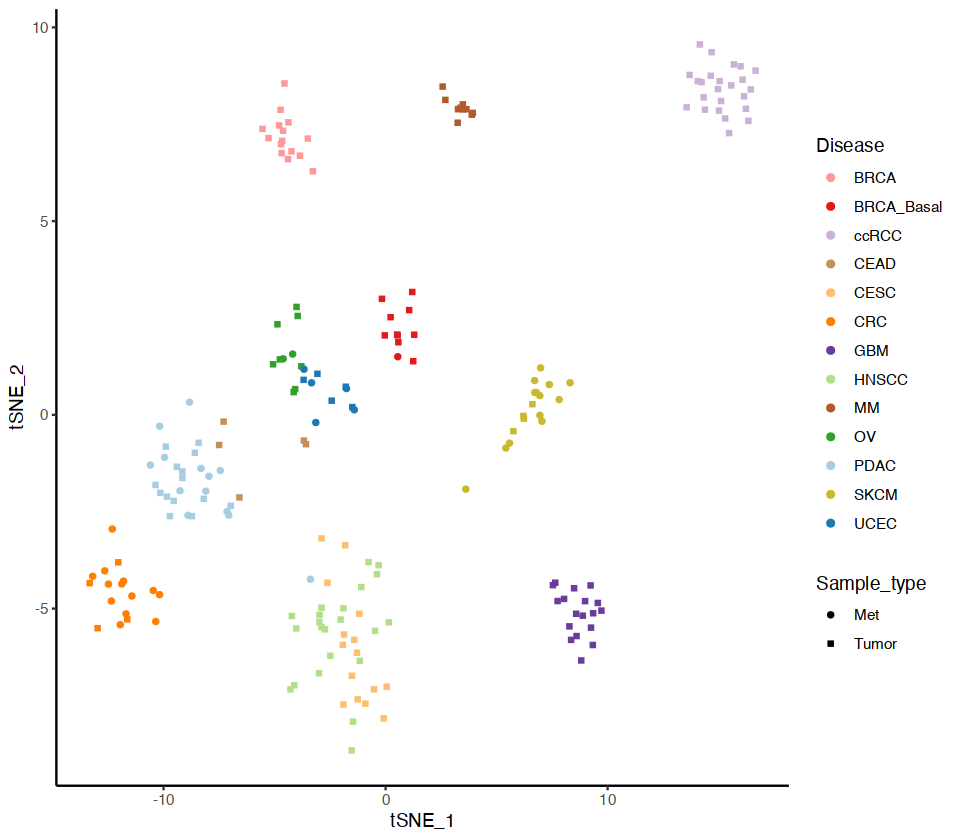

In [11]:
options(repr.plot.width=8, repr.plot.height=7)
plot